In [1]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

from mrcnn.visualize import display_instances, display_top_masks
from mrcnn.utils import extract_bboxes

from mrcnn.utils import Dataset
from matplotlib import pyplot as plt

from mrcnn.config import Config
from mrcnn.model import MaskRCNN

from mrcnn import model as modellib, utils
from PIL import Image, ImageDraw

Using TensorFlow backend.


In [2]:
import imgaug

In [2]:
import random
import math
import re
import time
import tensorflow as tf
import matplotlib
import matplotlib.patches as patches

In [3]:
from mrcnn import visualize
from mrcnn.visualize import display_images

from mrcnn.model import log

%matplotlib inline

In [4]:
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

from mrcnn.visualize import display_instances, display_top_masks
from mrcnn.utils import extract_bboxes

import skimage.draw
from matplotlib import pyplot as plt

In [5]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [6]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('hoof_side/train/labels/growth_coco.json', 'hoof_side/train')
dataset_train.prepare()

In [7]:
dataset_val = CocoLikeDataset()
dataset_val.load_data('hoof_side/val/labels/val_growth_coco.json', 'hoof_side/val')
dataset_val.prepare()

In [8]:
dataset_test = CocoLikeDataset()
dataset_test.load_data('hoof_side/test/labels/test_growth_coco.json', 'hoof_side/test')
dataset_test.prepare()

In [9]:
print("Images: {}\nClasses: {}".format(len(dataset_val.image_ids), dataset_val.class_names))

Images: 22
Classes: ['BG', 'side_growth_0', 'side_growth_1', 'side_growth_2']


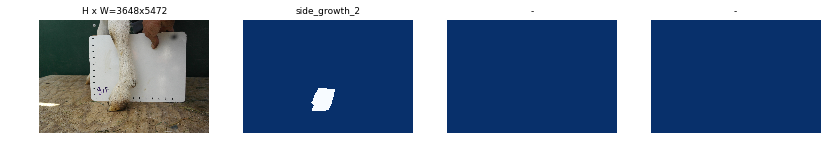

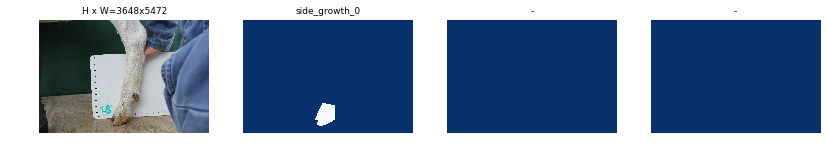

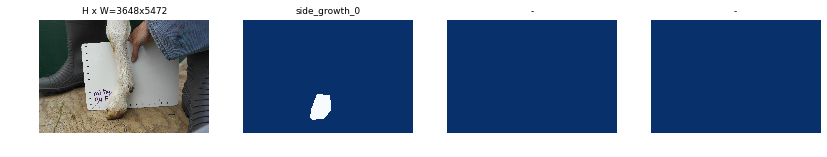

In [10]:
dataset = dataset_train
#image_ids = dataset.image_ids
image_ids = np.random.choice(dataset.image_ids, 3)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    display_top_masks(image, mask, class_ids, dataset.class_names, limit=3)  #limit to total number of classes


In [11]:
# define image id
image_id = 10
# load the image
image = dataset_train.load_image(image_id)
# load the masks and the class ids
mask, class_ids = dataset_train.load_mask(image_id)

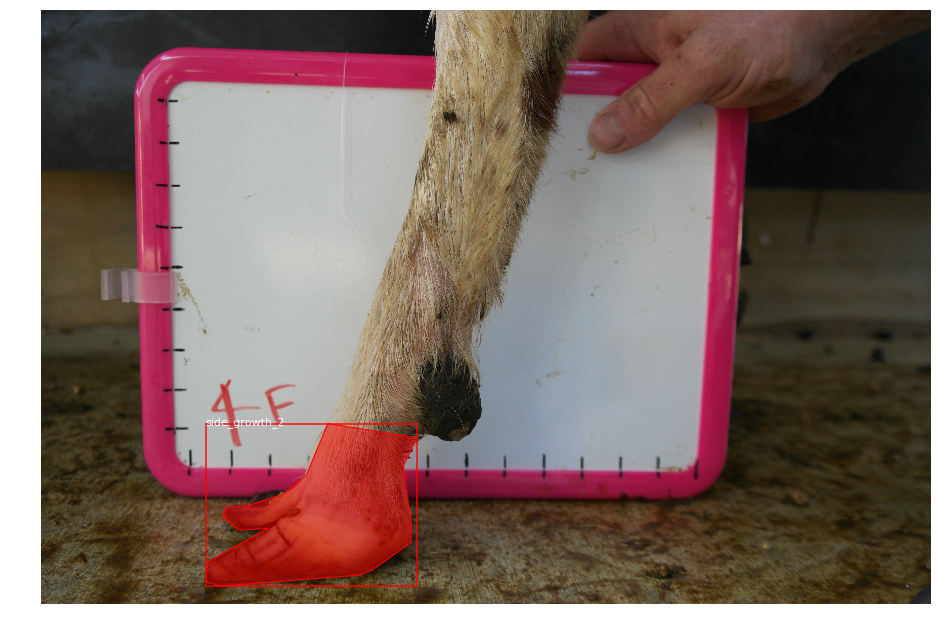

In [12]:
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

In [13]:
# define a configuration for the model
class HoofConfig(Config):
	# define the name of the configuration
	NAME = "hoof_growth_cfg_coco"
	# number of classes (background + growth 0 + growth 1 + growth 2)
	NUM_CLASSES = 1 + 3
	# number of training steps per epoch
	STEPS_PER_EPOCH = 83
    #DETECTION_MIN_CONFIDENCE = 0.9 # Skip detections with < 90% confidence
	LEARNING_RATE = 0.001
	IMAGES_PER_GPU = 2
    
# prepare config
config = HoofConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [21]:
ROOT_DIR = os.path.abspath("./")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
# Directory to save logs and trained model
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [22]:
#define the model
model = MaskRCNN(mode='training', model_dir=DEFAULT_LOGS_DIR, config=config)

In [23]:
#load weights (mscoco) and exclude the output layers
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

In [24]:
#train weights (output layers or 'heads')
model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE, epochs=40, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /scale_wlg_persistent/filesets/project/agresearch03746/Mask-RCNN-TF2/logs/hoof_fetlock_cfg_coco20230201T1946/mask_rcnn_hoof_fetlock_cfg_coco_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2

/scale_wlg_persistent/filesets/project/agresearch03746/Mask-RCNN-TF2/venv_gpu/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/scale_wlg_persistent/filesets/project/agresearch03746/Mask-RCNN-TF2/venv_gpu/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/scale_wlg_persistent/filesets/project/agresearch03746/Mask-RCNN-TF2/venv_gpu/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memo

Epoch 1/40


/scale_wlg_persistent/filesets/project/agresearch03746/Mask-RCNN-TF2/venv_gpu/lib/python3.7/site-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


 2/83 [..............................] - ETA: 2:22:28 - loss: 5.1121

/scale_wlg_persistent/filesets/project/agresearch03746/Mask-RCNN-TF2/venv_gpu/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (2.088250). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


83/83 [==============================] - 352s 4s/step - loss: 0.7764 - val_loss: 1.9702
Epoch 2/40
83/83 [==============================] - 138s 2s/step - loss: 0.1954 - val_loss: 0.4379
Epoch 3/40
83/83 [==============================] - 139s 2s/step - loss: 0.1187 - val_loss: 0.9054
Epoch 4/40
83/83 [==============================] - 137s 2s/step - loss: 0.0831 - val_loss: 1.2147
Epoch 5/40
83/83 [==============================] - 134s 2s/step - loss: 0.0729 - val_loss: 0.9986
Epoch 6/40
83/83 [==============================] - 141s 2s/step - loss: 0.0789 - val_loss: 1.1784
Epoch 7/40
83/83 [==============================] - 132s 2s/step - loss: 0.1326 - val_loss: 0.8243
Epoch 8/40
83/83 [==============================] - 134s 2s/step - loss: 0.0941 - val_loss: 1.5978
Epoch 9/40
83/83 [==============================] - 136s 2s/step - loss: 0.0782 - val_loss: 0.9004
Epoch 10/40
83/83 [==============================] - 133s 2s/step - loss: 0.0819 - val_loss: 0.7592
Epoch 11/40
83/83 [=

#Inference and Predictions

In [14]:
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap
from numpy import expand_dims
from numpy import mean
from matplotlib.patches import Rectangle

In [15]:
# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "hoof_growth_cfg_coco"
	# number of classes (background + growth 0 + growth 1 + growth 2)
	NUM_CLASSES = 1 + 3
	# Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

In [16]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP

In [17]:
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='logs', config=cfg)

In [ ]:
# load model weights
model.load_weights('logs/hoof_growth_cfg_coco20230201T0830/mask_rcnn_hoof_growth_cfg_coco_0024.h5', by_name=True)
# evaluate model on training dataset
train_mAP = evaluate_model(dataset_train, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on val dataset
val_mAP = evaluate_model(dataset_val, model, cfg)
print("Val mAP: %.3f" % val_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(dataset_test, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Re-starting from epoch 25
Train mAP: 0.398
Val mAP: 0.404


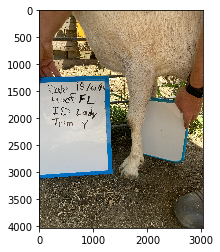

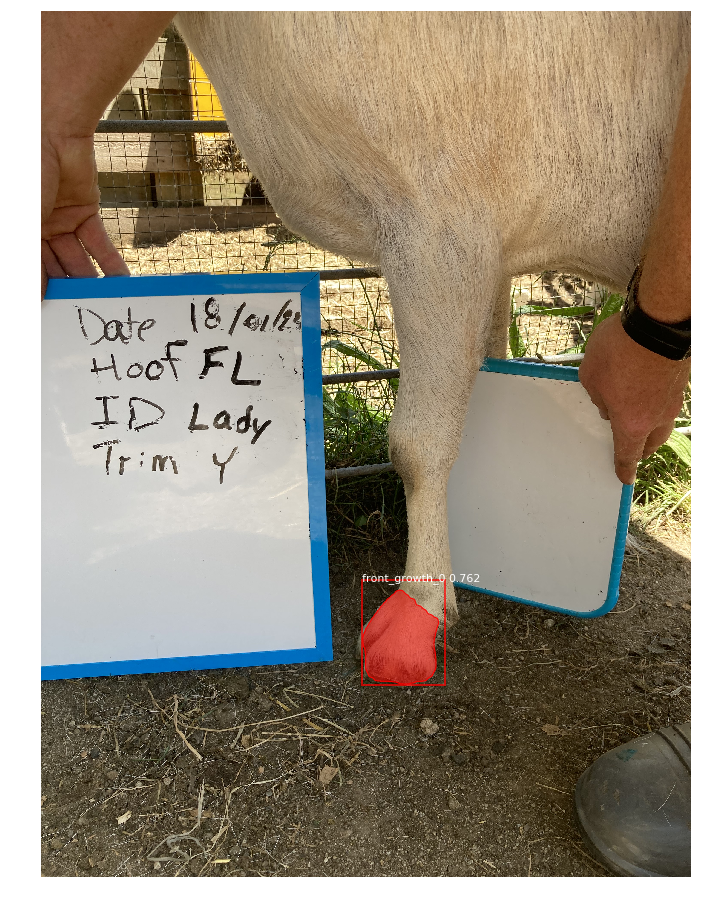

In [21]:
#Test on a single image
hoof_img = skimage.io.imread("hoof_side/test/IMG_6154.JPG")
plt.imshow(hoof_img)

detected = model.detect([hoof_img])
results = detected[0] 
class_names = ['BG','front_growth_0', 'front_growth_1', 'front_growth_2']
display_instances(hoof_img, results['rois'], results['masks'], 
                  results['class_ids'], class_names, results['scores'])

In [22]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [23]:
#Run detection
image_id = random.choice(dataset_val.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_val.image_reference(image_id)))


image ID: coco_like.11 (10) 


In [24]:
# Run object detection
results = model.detect([image], verbose=1)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  497.00000  max:  886.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


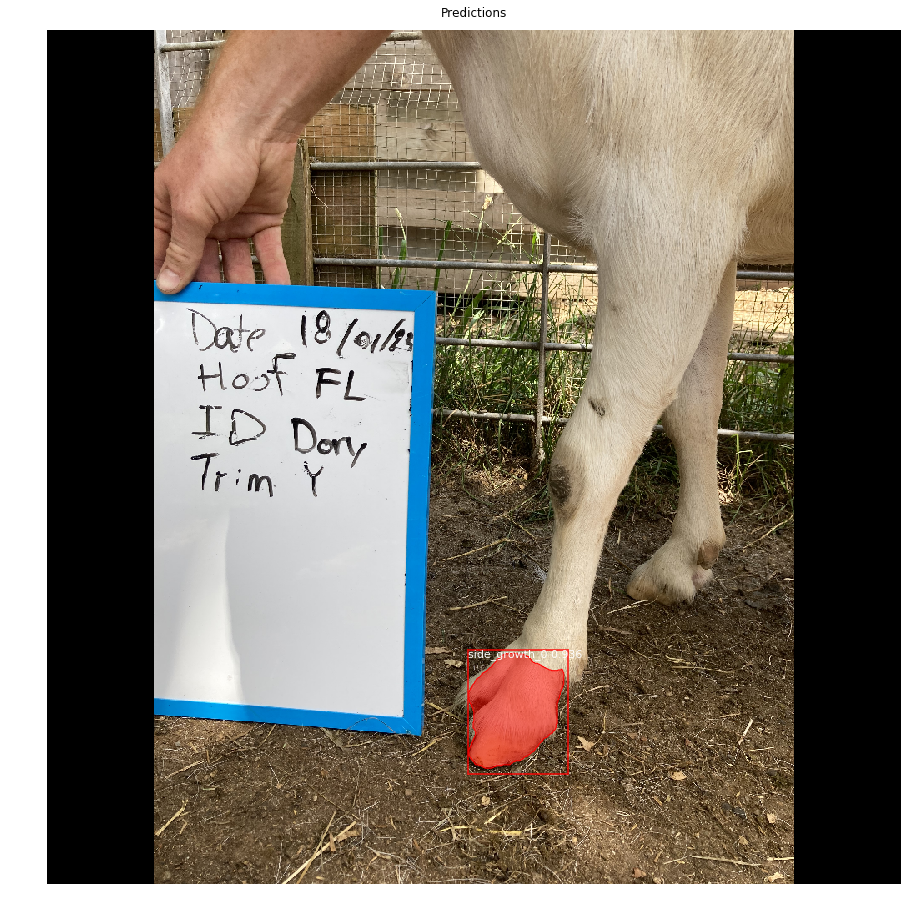

In [25]:
# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

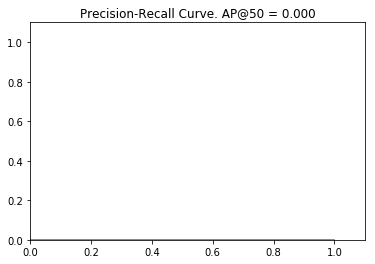

In [27]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

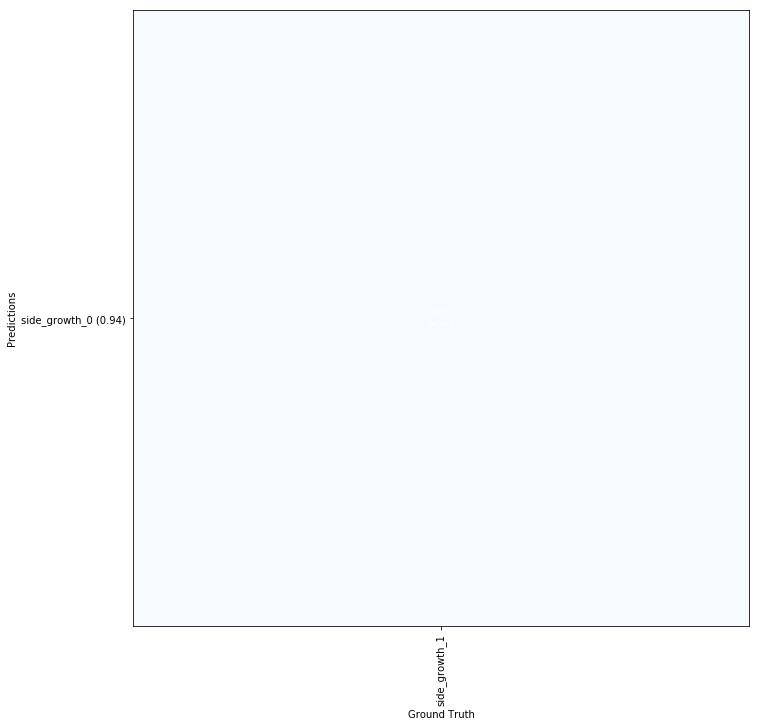

In [28]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset_val.class_names)

In [29]:
def test_image(image_path=None):
    hoof_img = skimage.io.imread(image_path)
    detected = model.detect([hoof_img])
    results = detected[0]
    class_names = ['BG','side_growth_0', 'side_growth_1', 'side_growth_2']
    return (f"Hoof conformation class is {class_names[results['class_ids'][0]]} and probabilty is {str(round(results['scores'][0],2))}")
#    return class_names[results['class_ids'][0]], results['scores'][0]

In [30]:
test_image(image_path="hoof_side/test/IMG_6154.JPG")

'Hoof conformation class is side_growth_0 and probabilty is 0.76'